In [2]:
from pyiron_workflow import Workflow
import pyvista
from dolfinx import mesh, fem, plot, io, default_scalar_type
from dolfinx.fem.petsc import LinearProblem
from mpi4py import MPI
import ufl
import numpy as np
from dolfinx.plot import vtk_mesh
from dolfinx.io import gmshio
import matplotlib.pyplot as plt
from dolfinx import geometry
import gmsh

In [3]:
pyvista.start_xvfb()

In [4]:
gmsh.initialize()

In [5]:
@Workflow.wrap.as_function_node()
def create_sample(x0, y0, z0, rx, ry, gdim, min_mesh, max_mesh):
    gmsh.clear()
    membrane = gmsh.model.occ.addDisk(x0, y0, z0, rx, ry)
    gmsh.model.occ.synchronize()
    gdim = gdim
    gmsh.model.addPhysicalGroup(gdim, [membrane], 1)
    gmsh.option.setNumber("Mesh.CharacteristicLengthMin", min_mesh)
    gmsh.option.setNumber("Mesh.CharacteristicLengthMax", max_mesh)
    gmsh.model.mesh.generate(gdim)
    gmsh_model_rank = 0
    mesh_comm = MPI.COMM_WORLD
    domain, cell_markers, facet_markers = gmshio.model_to_mesh(gmsh.model, mesh_comm, gmsh_model_rank, gdim=gdim)
    return domain

In [6]:
@Workflow.wrap.as_function_node()
def create_space(domain, el_type, el_order):
    V = fem.functionspace(domain, (el_type, el_order))
    return V

In [7]:
@Workflow.wrap.as_function_node()
def plot_mesh(V):
    plotter = pyvista.Plotter()
    topology, cell_types, geometry = plot.vtk_mesh(V)
    grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
    plotter.add_mesh(grid, show_edges=True)
    return plotter

In [8]:
@Workflow.wrap.as_function_node()
def boundary_conditions(V, bc_function):
    boundary_dofs = fem.locate_dofs_geometrical(V, bc_function)
    bc = fem.dirichletbc(default_scalar_type(0), boundary_dofs, V)
    return bc

In [9]:
@Workflow.wrap.as_function_node()
def define_load(domain, beta_val, R0_val):
    x = ufl.SpatialCoordinate(domain)
    beta = fem.Constant(domain, default_scalar_type(beta_val))
    R0 = fem.Constant(domain, default_scalar_type(R0_val))
    p = 4 * ufl.exp(-beta**2 * (x[0]**2 + (x[1] - R0)**2))
    return p

In [10]:
@Workflow.wrap.as_function_node()
def solve_poisson(V, p, bc):
    u = ufl.TrialFunction(V)
    v = ufl.TestFunction(V)
    a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
    L = p * v * ufl.dx
    problem = LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
    uh = problem.solve()
    return uh

In [11]:
@Workflow.wrap.as_function_node()
def plot_deformed(V, uh):
    topology, cell_types, x = vtk_mesh(V)
    grid = pyvista.UnstructuredGrid(topology, cell_types, x)
    grid.point_data["u"] = uh.x.array
    warped = grid.warp_by_scalar("u", factor=25)
    plotter = pyvista.Plotter()
    plotter.add_mesh(warped, show_edges=True, show_scalar_bar=True, scalars="u")
    return plotter

In [12]:
@Workflow.wrap.as_function_node()
def plot_load(domain, p):
    Q = fem.functionspace(domain, ("Lagrange", 5))
    expr = fem.Expression(p, Q.element.interpolation_points())
    pressure = fem.Function(Q)
    pressure.interpolate(expr)
    plotter = pyvista.Plotter()
    p_grid = pyvista.UnstructuredGrid(*vtk_mesh(Q))
    p_grid.point_data["p"] = pressure.x.array.real
    warped_p = p_grid.warp_by_scalar("p", factor=0.5)
    warped_p.set_active_scalars("p")
    plotter.add_mesh(warped_p, show_edges=False, show_scalar_bar=True)
    return plotter

In [21]:
@Workflow.wrap.as_function_node()
def plot_load_deflection_line(domain, uh, p):
    Q = fem.functionspace(domain, ("Lagrange", 5))
    expr = fem.Expression(p, Q.element.interpolation_points())
    pressure = fem.Function(Q)
    pressure.interpolate(expr)
    tol = 0.001  # Avoid hitting the outside of the domain
    y = np.linspace(-1 + tol, 1 - tol, 101)
    points = np.zeros((3, 101))
    points[1] = y
    u_values = []
    p_values = []
    bb_tree = geometry.bb_tree(domain, domain.topology.dim)
    cells = []
    points_on_proc = []
    # Find cells whose bounding-box collide with the the points
    cell_candidates = geometry.compute_collisions_points(bb_tree, points.T)
    # Choose one of the cells that contains the point
    colliding_cells = geometry.compute_colliding_cells(domain, cell_candidates, points.T)
    for i, point in enumerate(points.T):
        if len(colliding_cells.links(i)) > 0:
            points_on_proc.append(point)
            cells.append(colliding_cells.links(i)[0])

    points_on_proc = np.array(points_on_proc, dtype=np.float64)
    u_values = uh.eval(points_on_proc, cells)
    p_values = pressure.eval(points_on_proc, cells)
    x_points = points_on_proc[:, 1]
    temp  = np.concatenate((u_values, p_values), axis=1)
    u_p_values = np.concatenate((x_points[:,None], temp), axis=1)
    return u_p_values

In [22]:
wf = Workflow("poisson_membrane")
wf.domain = create_sample(0, 0, 0, 1, 1, 2, 0.03, 0.03)
wf.V = create_space(wf.domain, "Lagrange", 1)
wf.plotter_mesh = plot_mesh(wf.V)

def on_boundary(x):
    return np.isclose(np.sqrt(x[0]**2 + x[1]**2), 1)

wf.bc = boundary_conditions(wf.V, on_boundary)
wf.p = define_load(wf.domain, 8, 0.6)

wf.uh = solve_poisson(wf.V, wf.p, wf.bc)
wf.plotter_defomed = plot_deformed(wf.V, wf.uh)
wf.plotter_load  = plot_load(wf.domain, wf.p)
wf.u_p_values = plot_load_deflection_line(wf.domain, wf.uh, wf.p)

wf()

Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Meshing 1D...
Info    : Meshing curve 1 (Ellipse)
Info    : Done meshing 1D (Wall 0.000140173s, CPU 0.000212s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.119963s, CPU 0.119638s)
Info    : 4201 nodes 8401 elements


{'plotter_mesh__plotter': <pyvista.plotting.plotter.Plotter at 0x7327d675de90>,
 'plotter_defomed__plotter': <pyvista.plotting.plotter.Plotter at 0x7327d6709f90>,
 'plotter_load__plotter': <pyvista.plotting.plotter.Plotter at 0x732817f4f910>,
 'u_p_values__u_p_values': array([[-9.99000000e-01,  7.05707438e-06,  3.99114852e-71],
        [-9.79020000e-01,  1.65823045e-04,  2.00101004e-69],
        [-9.59040000e-01,  3.26543340e-04,  1.10299177e-67],
        [-9.39060000e-01,  4.91190919e-04,  5.81012062e-66],
        [-9.19080000e-01,  6.59417964e-04,  2.93010789e-64],
        [-8.99100000e-01,  8.30566105e-04,  1.37792359e-62],
        [-8.79120000e-01,  1.00470615e-03,  6.22448789e-61],
        [-8.59140000e-01,  1.18385295e-03,  2.64551812e-59],
        [-8.39160000e-01,  1.36673400e-03,  1.08143410e-57],
        [-8.19180000e-01,  1.55341913e-03,  4.13305557e-56],
        [-7.99200000e-01,  1.74452171e-03,  1.53866994e-54],
        [-7.79220000e-01,  1.93974771e-03,  5.34695009e-53],

In [35]:
wf.domain.run()

In [23]:
pic = wf.draw()

In [1]:
pic.render(outfile='workflow.svg')

NameError: name 'pic' is not defined

In [2]:
pic.render(format='png')

NameError: name 'pic' is not defined

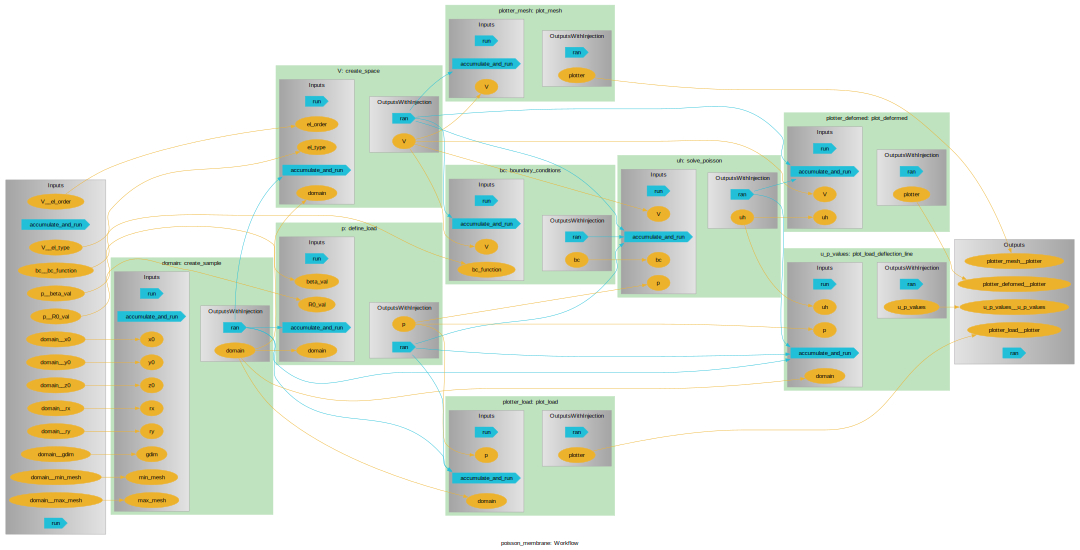

In [26]:
wf.draw(size=(15,15))

In [27]:
wf.outputs.to_list()[0].show()

Widget(value='<iframe src="http://localhost:37307/index.html?ui=P_0x7327d675de90_4&reconnect=auto" class="pyvi…

In [28]:
wf.outputs.to_list()[1].show()

Widget(value='<iframe src="http://localhost:37307/index.html?ui=P_0x7327d6709f90_5&reconnect=auto" class="pyvi…

In [29]:
wf.outputs.to_list()[2].show()

Widget(value='<iframe src="http://localhost:37307/index.html?ui=P_0x732817f4f910_3&reconnect=auto" class="pyvi…

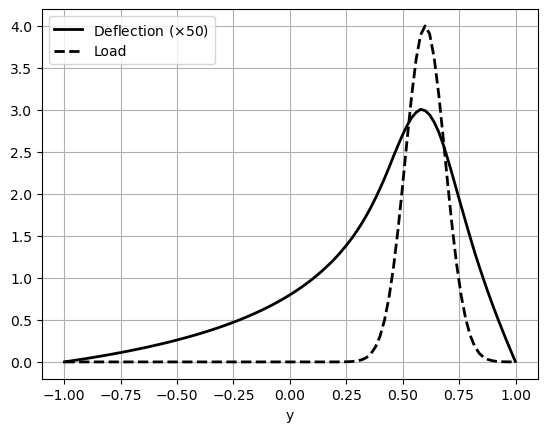

In [30]:
fig = plt.figure()
plt.plot(wf.outputs.to_list()[3][:,0], 50 * wf.outputs.to_list()[3][:,1], "k", linewidth=2, label="Deflection ($\\times 50$)")
plt.plot(wf.outputs.to_list()[3][:,0], wf.outputs.to_list()[3][:,2], "k--", linewidth=2, label="Load")
plt.grid(True)
plt.xlabel("y")
plt.legend()
# If run in parallel as a python file, we save a plot per processor
plt.savefig(f"membrane_rank{MPI.COMM_WORLD.rank:d}.png")

In [153]:
wf.V._repr_json_()

{'label': 'V',
 'ready': True,
 'connected': True,
 'fully_connected': False,
 'inputs': {'label': 'Inputs',
  'connected': True,
  'fully_connected': False,
  'channels': {'domain': {'label': 'domain',
    'connected': True,
    'connections': ['domain.domain'],
    'value': '<dolfinx.mesh.Mesh object at 0x729baea15d10>',
    'ready': True,
    'type_hint': 'None'},
   'el_type': {'label': 'el_type',
    'connected': False,
    'connections': [],
    'value': "'Lagrange'",
    'ready': True,
    'type_hint': 'None'},
   'el_order': {'label': 'el_order',
    'connected': False,
    'connections': [],
    'value': '1',
    'ready': True,
    'type_hint': 'None'}},
  'ready': True},
 'outputs': {'label': 'OutputsWithInjection',
  'connected': True,
  'fully_connected': True,
  'channels': {'V': {'label': 'V',
    'connected': True,
    'connections': ['bc.V',
     'bc.V',
     'plotter_defomed.V',
     'uh.V',
     'bc.V',
     'plotter_mesh.V'],
    'value': 'FunctionSpace(Mesh(blocked 

## Now loop individual functions

In [126]:
wf_lf = Workflow("poisson_membrane_loop_functions")
wf_lf.domain = create_sample(0, 0, 0, 1, 1, 2, 0.03, 0.03)
wf_lf.V = create_space(wf_lf.domain, "Lagrange", 1)

def on_boundary(x):
    return np.isclose(np.sqrt(x[0]**2 + x[1]**2), 1)

wf_lf.bc = boundary_conditions(wf_lf.V, on_boundary)
wf_lf.p_beta_5 = define_load(wf_lf.domain, 5, 0.6)
wf_lf.p_beta_6 = define_load(wf_lf.domain, 6, 0.6)
wf_lf.p_beta_8 = define_load(wf_lf.domain, 8, 0.6)
wf_lf.p_beta_10 = define_load(wf_lf.domain, 10, 0.6)

wf_lf.uh_beta_5 = solve_poisson(wf_lf.V, wf_lf.p_beta_5, wf_lf.bc)
wf_lf.uh_beta_6 = solve_poisson(wf_lf.V, wf_lf.p_beta_6, wf_lf.bc)
wf_lf.uh_beta_8 = solve_poisson(wf_lf.V, wf_lf.p_beta_8, wf_lf.bc)
wf_lf.uh_beta_10 = solve_poisson(wf_lf.V, wf_lf.p_beta_10, wf_lf.bc)
wf_lf.u_p_values_beta_5 = plot_load_deflection_line(wf_lf.domain, wf_lf.uh_beta_5, wf_lf.p_beta_5)
wf_lf.u_p_values_beta_6 = plot_load_deflection_line(wf_lf.domain, wf_lf.uh_beta_6, wf_lf.p_beta_6)
wf_lf.u_p_values_beta_8 = plot_load_deflection_line(wf_lf.domain, wf_lf.uh_beta_8, wf_lf.p_beta_8)
wf_lf.u_p_values_beta_10 = plot_load_deflection_line(wf_lf.domain, wf_lf.uh_beta_10, wf_lf.p_beta_10)

wf_lf()

Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Meshing 1D...
Info    : Meshing curve 1 (Ellipse)
Info    : Done meshing 1D (Wall 0.000163817s, CPU 0.000227s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.122788s, CPU 0.122788s)
Info    : 4201 nodes 8401 elements


{'u_p_values_beta_5__u_p_values': array([[-9.99000000e-01,  1.80707232e-05,  6.95027849e-28],
        [-9.79020000e-01,  4.24615384e-04,  3.39903444e-27],
        [-9.59040000e-01,  8.36164391e-04,  1.62962285e-26],
        [-9.39060000e-01,  1.25776981e-03,  7.65886811e-26],
        [-9.19080000e-01,  1.68854099e-03,  3.52839737e-25],
        [-8.99100000e-01,  2.12679208e-03,  1.59329870e-24],
        [-8.79120000e-01,  2.57270439e-03,  7.05311770e-24],
        [-8.59140000e-01,  3.03143725e-03,  3.06024949e-23],
        [-8.39160000e-01,  3.49973220e-03,  1.30164459e-22],
        [-8.19180000e-01,  3.97776806e-03,  5.42684108e-22],
        [-7.99200000e-01,  4.46711546e-03,  2.21794214e-21],
        [-7.79220000e-01,  4.96702148e-03,  8.88507209e-21],
        [-7.59240000e-01,  5.47761077e-03,  3.48917283e-20],
        [-7.39260000e-01,  5.99950699e-03,  1.34312092e-19],
        [-7.19280000e-01,  6.53556719e-03,  5.06786791e-19],
        [-6.99300000e-01,  7.08732604e-03,  1.874454

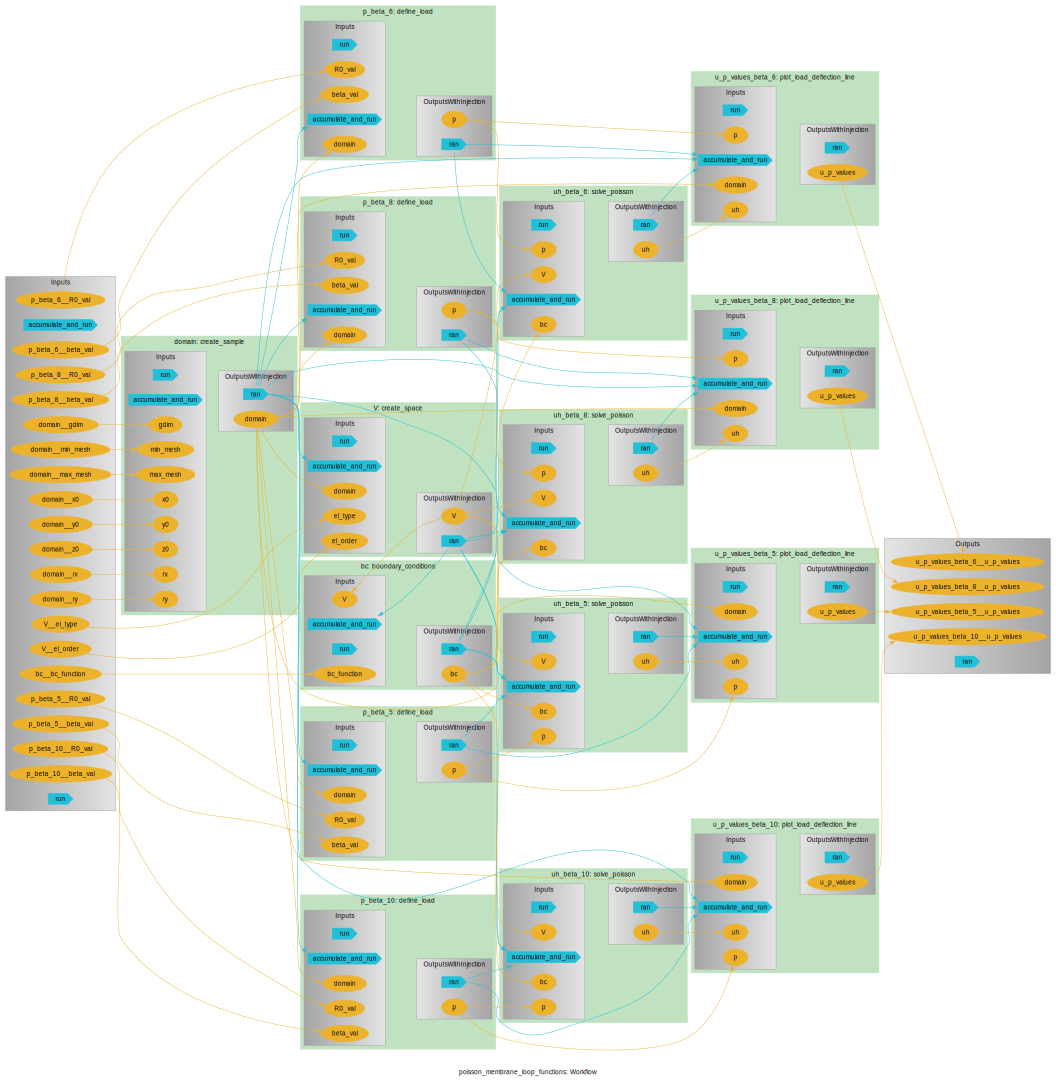

In [128]:
wf_lf.draw(size=(15,15))

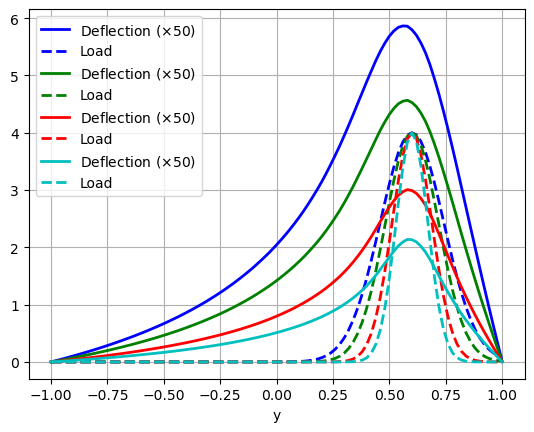

In [134]:
fig = plt.figure()
plt.plot(wf_lf.outputs.to_list()[0][:,0], 50 * wf_lf.outputs.to_list()[0][:,1], "b", linewidth=2, label="Deflection ($\\times 50$)")
plt.plot(wf_lf.outputs.to_list()[0][:,0], wf_lf.outputs.to_list()[0][:,2], "b--", linewidth=2, label="Load")
plt.plot(wf_lf.outputs.to_list()[1][:,0], 50 * wf_lf.outputs.to_list()[1][:,1], "g", linewidth=2, label="Deflection ($\\times 50$)")
plt.plot(wf_lf.outputs.to_list()[1][:,0], wf_lf.outputs.to_list()[1][:,2], "g--", linewidth=2, label="Load")
plt.plot(wf_lf.outputs.to_list()[2][:,0], 50 * wf_lf.outputs.to_list()[2][:,1], "r", linewidth=2, label="Deflection ($\\times 50$)")
plt.plot(wf_lf.outputs.to_list()[2][:,0], wf_lf.outputs.to_list()[2][:,2], "r--", linewidth=2, label="Load")
plt.plot(wf_lf.outputs.to_list()[3][:,0], 50 * wf_lf.outputs.to_list()[3][:,1], "c", linewidth=2, label="Deflection ($\\times 50$)")
plt.plot(wf_lf.outputs.to_list()[3][:,0], wf_lf.outputs.to_list()[3][:,2], "c--", linewidth=2, label="Load")
plt.grid(True)
plt.xlabel("y")
plt.legend()

## Now as macro to loop

In [111]:
@Workflow.wrap.as_macro_node()
def poisson_membrane_caculate(self, beta, bc_function):
    self.domain = create_sample(0, 0, 0, 1, 1, 2, 0.03, 0.03)
    self.V = create_space(self.domain, "Lagrange", 1)
    self.bc = boundary_conditions(self.V, bc_function)
    self.p = define_load(self.domain, beta, 0.6)
    self.uh = solve_poisson(self.V, self.p, self.bc)
    self.u_p_values = plot_load_deflection_line(self.domain, self.uh, self.p)
    return self.u_p_values

In [120]:
wf_loop = Workflow("poisson_membrane_loop_macro")

def on_boundary(x):
    return np.isclose(np.sqrt(x[0]**2 + x[1]**2), 1)

wf_loop.beta_5 = poisson_membrane_caculate(5, on_boundary)
wf_loop.beta_6 = poisson_membrane_caculate(6, on_boundary)
wf_loop.beta_8 = poisson_membrane_caculate(8, on_boundary)
wf_loop.beta_10 = poisson_membrane_caculate(10, on_boundary)

wf_loop()

Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Meshing 1D...
Info    : Meshing curve 1 (Ellipse)
Info    : Done meshing 1D (Wall 0.000306294s, CPU 0.00035s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.138342s, CPU 0.138344s)
Info    : 4201 nodes 8401 elements
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Meshing 1D...
Info    : Meshing curve 1 (Ellipse)
Info    : Done meshing 1D (Wall 0.000135684s, CPU 0.000172s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.12393s, CPU 0.12443s)
Info    : 4201 nodes 8401 elements
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Meshing 1D...
Info    : Meshing curve 1 (Ellipse)
Info    : Done meshing 1D (Wall 0.000146184s, CPU 0.000216s)
Info    : Meshing 2D...
Info    : 

{'beta_5__u_p_values': array([[-9.99000000e-01,  1.80707232e-05,  6.95027849e-28],
        [-9.79020000e-01,  4.24615384e-04,  3.39903444e-27],
        [-9.59040000e-01,  8.36164391e-04,  1.62962285e-26],
        [-9.39060000e-01,  1.25776981e-03,  7.65886811e-26],
        [-9.19080000e-01,  1.68854099e-03,  3.52839737e-25],
        [-8.99100000e-01,  2.12679208e-03,  1.59329870e-24],
        [-8.79120000e-01,  2.57270439e-03,  7.05311770e-24],
        [-8.59140000e-01,  3.03143725e-03,  3.06024949e-23],
        [-8.39160000e-01,  3.49973220e-03,  1.30164459e-22],
        [-8.19180000e-01,  3.97776806e-03,  5.42684108e-22],
        [-7.99200000e-01,  4.46711546e-03,  2.21794214e-21],
        [-7.79220000e-01,  4.96702148e-03,  8.88507209e-21],
        [-7.59240000e-01,  5.47761077e-03,  3.48917283e-20],
        [-7.39260000e-01,  5.99950699e-03,  1.34312092e-19],
        [-7.19280000e-01,  6.53556719e-03,  5.06786791e-19],
        [-6.99300000e-01,  7.08732604e-03,  1.87445447e-18],
  

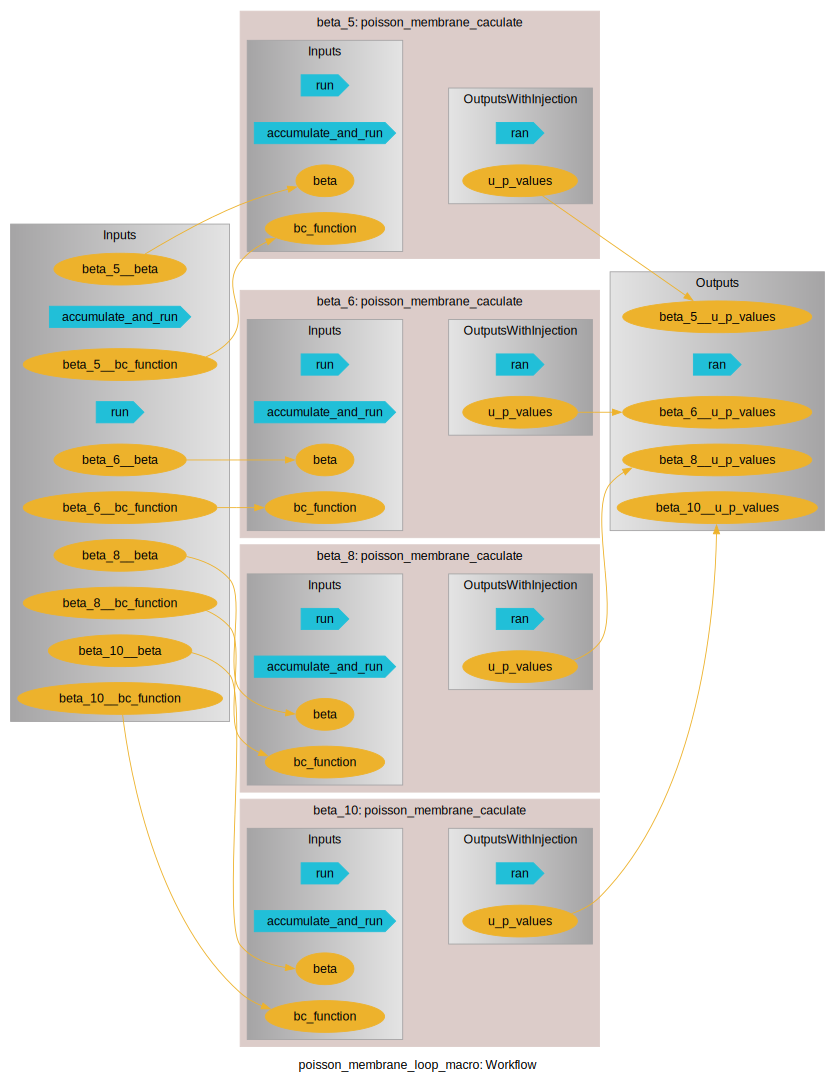

In [121]:
wf_loop.draw(size=(15,15))

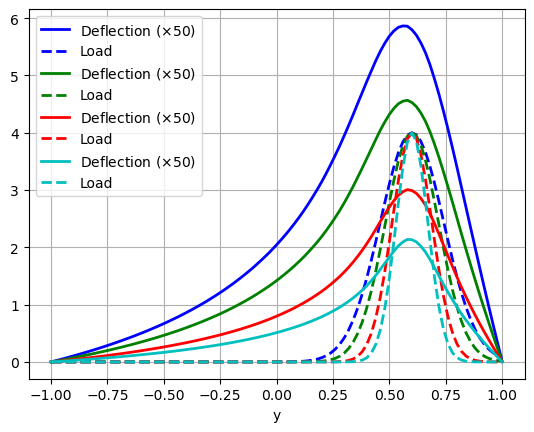

In [122]:
fig = plt.figure()
plt.plot(wf_loop.outputs.to_list()[0][:,0], 50 * wf_loop.outputs.to_list()[0][:,1], "b", linewidth=2, label="Deflection ($\\times 50$)")
plt.plot(wf_loop.outputs.to_list()[0][:,0], wf_loop.outputs.to_list()[0][:,2], "b--", linewidth=2, label="Load")
plt.plot(wf_loop.outputs.to_list()[1][:,0], 50 * wf_loop.outputs.to_list()[1][:,1], "g", linewidth=2, label="Deflection ($\\times 50$)")
plt.plot(wf_loop.outputs.to_list()[1][:,0], wf_loop.outputs.to_list()[1][:,2], "g--", linewidth=2, label="Load")
plt.plot(wf_loop.outputs.to_list()[2][:,0], 50 * wf_loop.outputs.to_list()[2][:,1], "r", linewidth=2, label="Deflection ($\\times 50$)")
plt.plot(wf_loop.outputs.to_list()[2][:,0], wf_loop.outputs.to_list()[2][:,2], "r--", linewidth=2, label="Load")
plt.plot(wf_loop.outputs.to_list()[3][:,0], 50 * wf_loop.outputs.to_list()[3][:,1], "c", linewidth=2, label="Deflection ($\\times 50$)")
plt.plot(wf_loop.outputs.to_list()[3][:,0], wf_loop.outputs.to_list()[3][:,2], "c--", linewidth=2, label="Load")
plt.grid(True)
plt.xlabel("y")
plt.legend()

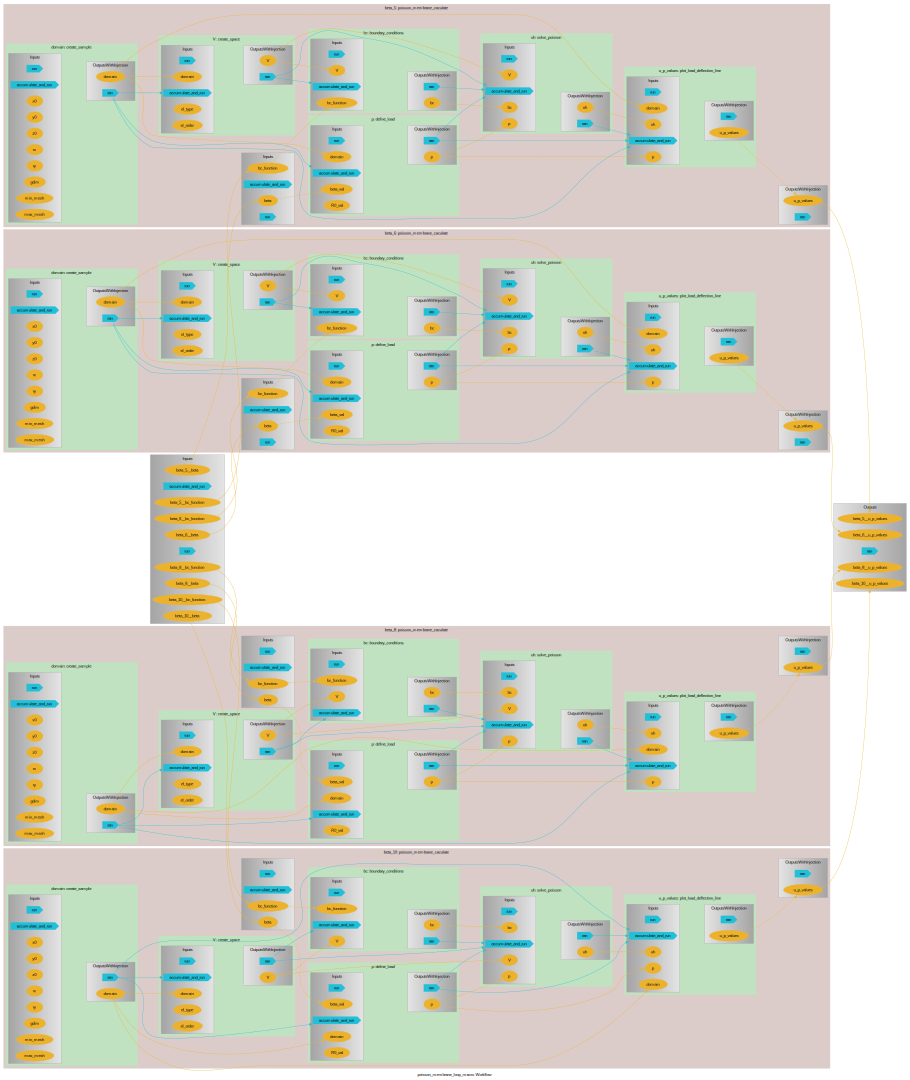

In [123]:
wf_loop.draw(size=(15, 15), depth=2)